In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import datetime as dt

%matplotlib inline  
plt.style.use('ggplot')

In [2]:
train_sample = pd.read_csv('train_sample.csv')
train_sample["click_time"] = pd.to_datetime(train_sample.click_time)
train_sample["date"] = pd.to_datetime(train_sample['click_time']).dt.date
train_sample["month"] = pd.to_datetime(train_sample['date']).dt.month
train_sample["day"] = pd.to_datetime(train_sample['date']).dt.day
train_sample["year"] = pd.to_datetime(train_sample['date']).dt.year

train_sample["time"] = pd.to_datetime(train_sample['click_time']).dt.time
train_sample[['hour','minute','second']] = pd.DataFrame([(x.hour, x.minute, x.second) for x in train_sample['time']])

In [3]:
train_sample.attributed_time = pd.to_datetime(train_sample.attributed_time)

In [112]:
train_sample_target = train_sample[train_sample.is_attributed == 1]

#### Data Snapshot

In [4]:
train_sample.head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed,date,month,day,year,time,hour,minute,second
0,87540,12,1,13,497,2017-11-07 09:30:38,NaT,0,2017-11-07,11,7,2017,09:30:38,9,30,38
1,105560,25,1,17,259,2017-11-07 13:40:27,NaT,0,2017-11-07,11,7,2017,13:40:27,13,40,27
2,101424,12,1,19,212,2017-11-07 18:05:24,NaT,0,2017-11-07,11,7,2017,18:05:24,18,5,24
3,94584,13,1,13,477,2017-11-07 04:58:08,NaT,0,2017-11-07,11,7,2017,04:58:08,4,58,8
4,68413,12,1,1,178,2017-11-09 09:00:09,NaT,0,2017-11-09,11,9,2017,09:00:09,9,0,9


#### Class Imbalance

In [90]:
pd.DataFrame(train_sample.is_attributed.value_counts())

,is_attributed
0,99773
1,227


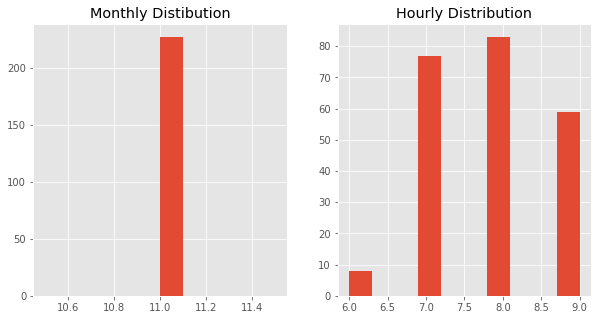

In [79]:
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.hist(train_sample[train_sample.is_attributed == 1].month)
plt.title("Monthly Distibution")
plt.subplot(122)
plt.hist(train_sample[train_sample.is_attributed == 1].day)
plt.title("Hourly Distribution")
plt.show()

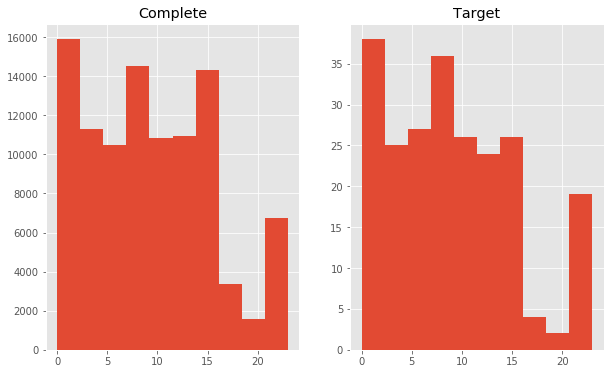

In [26]:
plt.figure(figsize=(10,6))
plt.subplot(1, 2, 1)
plt.hist(train_sample.hour)
plt.title("Complete")
plt.subplot(1, 2, 2)
plt.hist(train_sample[train_sample.is_attributed == 1].hour)
plt.title("Target")
plt.show()

The key takeaway from this comparision is the fact that, proportionally, there is a significant drop in downloads at 15:00.

In [5]:
for i in ["app","device","os","channel"]:
    
    print("Number of unique {}: {}".format(i, len(train_sample[i].unique())))

Number of unique app: 161
Number of unique device: 100
Number of unique os: 130
Number of unique channel: 161


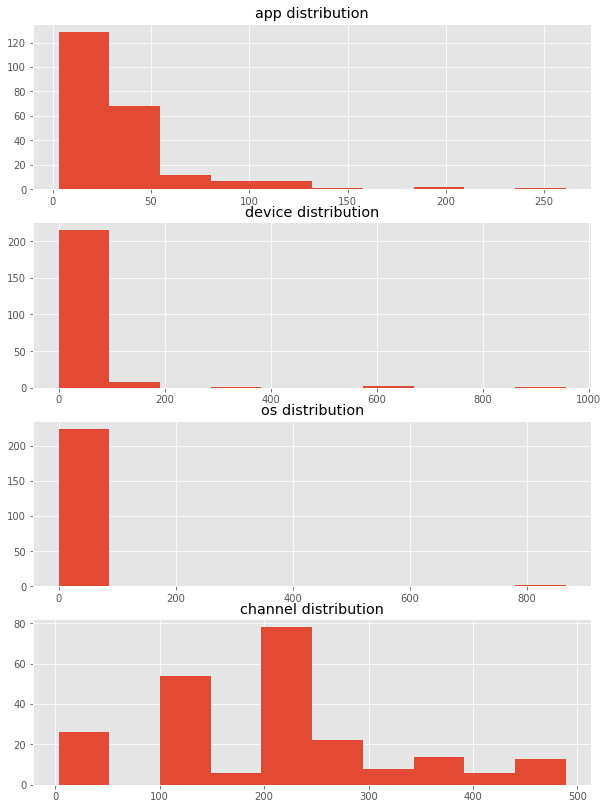

In [78]:
n = 4
a = plt.subplots(4, 1,figsize=(10,14))[1].ravel()

for ix, i in enumerate(["app","device","os","channel"]):

    a[ix].hist(train_sample[train_sample.is_attributed == 1][i])
    a[ix].set_title("{} distribution".format(i))

plt.show()

It seems as though `channel` is the only categorical variable that is following a normal distribution. `app, device, os` will all require some transformation. At first glance, `log()` should do the trick. Let's see:

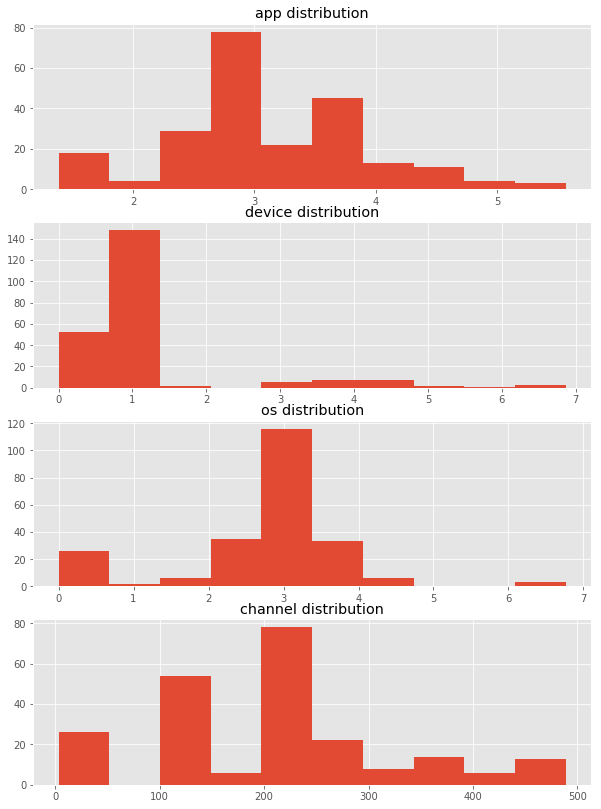

In [116]:
n = 4
a = plt.subplots(4, 1,figsize=(10,14))[1].ravel()

for ix, i in enumerate(["app","device","os"]):

    a[ix].hist(train_sample_target[i].apply(lambda x: np.log(x+1)))
    a[ix].set_title("{} distribution".format(i))

a[3].hist(train_sample_target["channel"])
a[3].set_title("{} distribution".format("channel"))

plt.show()

In [6]:
train_sample_target["time_diff"] = (train_sample_target.attributed_time - train_sample_target.click_time).dt.total_seconds()

C:\Users\mt16558\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


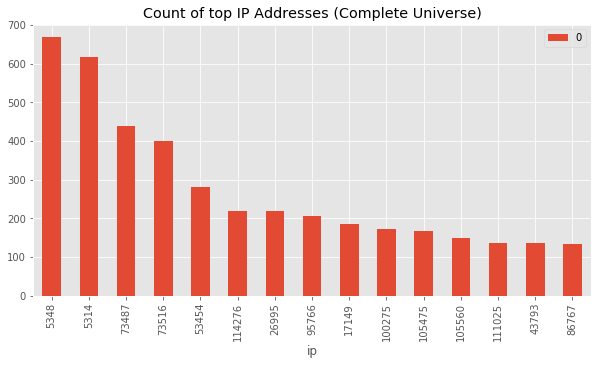

In [72]:
y = train_sample.groupby('ip').count()['os'].sort_values(ascending = False)[:15].values
x = train_sample.groupby('ip').count()['os'].sort_values(ascending = False)[:15].index
pd.DataFrame(y,x).plot.bar(title = "Count of top IP Addresses (Complete Universe)", figsize = (10,5))
plt.show()

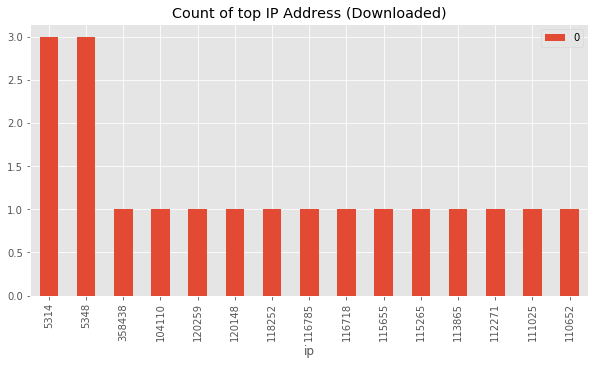

In [74]:
y = train_sample_target.groupby('ip').count()['os'].sort_values(ascending = False)[:15].values
x = train_sample_target.groupby('ip').count()['os'].sort_values(ascending = False)[:15].index
pd.DataFrame(y,x).plot.bar(title = "Count of top IP Address (Downloaded)" , figsize = (10,5))
plt.show()

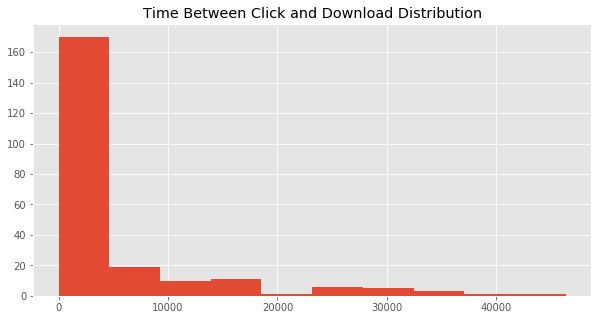

In [75]:
plt.figure(figsize=(10,5))
plt.hist(train_sample_target.time_diff)
plt.title("Time Between Click and Download Distribution")
plt.show()

In [102]:
for i in ["app","device","os","channel"]:
    print("Categorical Variable: {}".format(i))
    display(pd.DataFrame(train_sample.groupby(i).count()['ip'].sort_values(ascending = False)[:10]))


Categorical Variable: app


,ip
app,
3,18279
12,13198
2,11737
9,8992
15,8595
18,8315
14,5359
1,3135
13,2422


Categorical Variable: device


,ip
device,
1,94338
2,4345
0,541
3032,371
3543,151
3866,93
59,12
6,8
5,7


Categorical Variable: os


,ip
os,
19,23870
13,21223
17,5232
18,4830
22,4039
10,2816
8,2775
6,2520
15,2396


Categorical Variable: channel


,ip
channel,
280,8114
245,4802
107,4543
477,3960
134,3224
259,3130
265,3013
153,2954
178,2936


In [93]:
for i in ["app","device","os","channel"]:
    print("Categorical Variable: {}".format(i))
    display(pd.DataFrame(train_sample_target.groupby(i).count()["time_diff"].sort_values(ascending = False)[:10]))

Categorical Variable: app


,time_diff
app,
19,70
35,27
29,22
10,18
5,14
45,11
9,8
72,6
18,5


Categorical Variable: device


,time_diff
device,
1,146
0,52
16,3
97,3
2,2
21,2
50,1
4,1
6,1


Categorical Variable: os


,time_diff
os,
19,41
0,26
24,26
13,25
29,11
21,8
17,6
27,6
22,6


Categorical Variable: channel


,time_diff
channel,
213,72
113,31
21,19
101,13
274,12
347,11
5,5
171,5
282,5


In [80]:
top_timediff_device = train_sample_target.groupby("device").mean()["time_diff"].sort_values(ascending = False)[:10]

In [96]:
display(pd.DataFrame(top_timediff_device))

,time_diff
device,
102,27550.000000
188,14015.000000
21,11085.000000
2,10507.000000
1,4954.465753
0,3917.923077
4,2386.000000
16,1533.000000
30,763.000000
